<a href="https://colab.research.google.com/github/jjain0811/Categorical-Crime-Rate-Analysis-and-Prediction/blob/main/Category_Murder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade keras-hypetune
!pip install prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 5.1 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasRandomSearch, KerasGridSearch
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 15})

In [ ]:
### READ DATA ###

df = pd.read_csv('https://docs.google.com/spreadsheets/d/18UOUY4S-iFNxwdwHsNupFunhzgvkql1udtY4_KlBI0w/export?format=csv&gid=1787086033')

column_matter = 'Murder'
df.drop(['Victim Families and Children','The National Stolen Property Act of 1934'],axis=1,inplace=True)

# column_matter = 'Victim Families and Children'
# df.drop(['Murder','The National Stolen Property Act of 1934'],axis=1,inplace=True)

# column_matter = 'The National Stolen Property Act of 1934'
# df.drop(['Victim Families and Children','Murder'],axis=1,inplace=True)

# df = pd.read_csv('https://docs.google.com/spreadsheets/d/1diq5R_nTdc59vcwEtoaw3wMPJYAVlO7s0Pnc4PbBAek/export?format=csv&gid=0') # California Data
# column_matter = 'Crime Rate'

df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)
df[column_matter] = [int(float(a.replace(",",""))) for a in df[column_matter]] # Comment for california, Victim and Act
df["Population"] = [int(float(a.replace(",",""))) for a in df["Population"]] # Comment for california
df["Tourism"] = [int(float(a.replace(",",""))) for a in df["Tourism"]]
df[column_matter] = df[column_matter]*100000/df['Population'] # *100 for state, /10 for act and victim
print(df.columns)
df.tail()

In [ ]:
### ADJUST AND CLEAN DATA ###
n_attr = 8
n_tres = 7
df_external = pd.DataFrame(df.index)

for col in df.columns:

    # if df[col].dtype == object: # correct type
    #     df[col] = pd.to_numeric(df[col].str.replace(',', '.'))

    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans

    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

In [ ]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):

    for col in cols:

        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data

In [ ]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df = cycle_encode(df,['Tourism','Population'])
df.drop(['Tourism','Population'],axis=1,inplace=True)
n_attr = 10
n_tres = 9
df.head(15)

# df_external['month'] = df_external.date.dt.month
# df_external['day'] = df_external.date.dt.dayofweek
# df_external['hour'] = df_external.date.dt.hour

# df_external = cycle_encode(df_external, ['month','day','hour'])
# df_external.drop(['month','day','hour'], axis=1, inplace=True)
# df_external.set_index('date', inplace=True)

# print(df_external.shape)
# df_external.head()

In [ ]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(df, shuffle=False, train_size=0.8)
train_ext, test_ext = train_test_split(df_external, shuffle=False, train_size=0.8)

print(train.shape, test.shape)
print(train_ext.shape, test_ext.shape)

In [ ]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):

    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()

def plot_autocor(name, df):

    plt.figure(figsize=(16,4))

    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()

    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

In [ ]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

In [ ]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [ ]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0
for i in tqdm(range(1,3)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

In [ ]:
### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

# COMBINE VAR AND LSTM

In [ ]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###


def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):

    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data

    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id

    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1

    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))

    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    return np.squeeze(window_data, 1)


def set_seed(seed):

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):

    set_seed(33)

    opt = Adam()
    opt.lr = param['lr']

    inp = Input(shape=(look_back, n_attr))

    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='tanh', return_sequences=True)(x)
    out = TimeDistributed(Dense(n_tres))(x)

    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')

    return model


def get_model_finetune(param, kgs, look_ahead, look_back):

    set_seed(33)

    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())

    best_model_config.optimizer.lr = param['lr']

    return best_model_config

In [ ]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [256, 128, 96],
    'lr': [7e-4, 1e-3, 3e-3],
    'epochs': 200,
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025),
    'epochs': 200,
}

In [ ]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = var_result.fittedvalues

X_train = np.concatenate([
    train.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([
    var_result.fittedvalues, train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(
    X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = np.concatenate([test.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

In [ ]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [ ]:
### BUILD DATA GENERATOR ###

look_back = 3
look_ahead = 6

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)
X_fut = X_test
X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

X_fut_pred = create_windows(X_fut[4:], window_shape = look_back, end_id = -look_ahead)
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

In [ ]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)

kgs_var = KerasGridSearch(hypermodel, param_grid,
                          monitor='val_loss', greater_is_better=False, tuner_verbose=1)

kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.98514 at epoch 16

***** (2/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.98514 at epoch 16

***** (3/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 1.68201 at epoch 15

***** (4/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.68201 at epoch 15

***** (5/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 1.7686 at epoch 33

***** (6/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.7686 at epoch 33

***** (7/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.67965 at epoch 58

***** (8/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200,

In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'],
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 1.37058 at epoch 14

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 1.36898 at epoch 11

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 1.3792 at epoch 49

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 1.36275 at epoch 5

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 1.36056 at epoch 4

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 1.3794 at epoch 51

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 1.36673 at epoch 7

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 1.38636 at epoch 127

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 1.38358 at epoch 95

***** (10/20) *****
Search({'lr': 9.772977050450925e-05, 'epo

In [ ]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)

In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)

kgs = KerasGridSearch(hypermodel, param_grid,
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.98514 at epoch 16

***** (2/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.98514 at epoch 16

***** (3/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 1.68201 at epoch 15

***** (4/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.68201 at epoch 15

***** (5/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 1.7686 at epoch 33

***** (6/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.7686 at epoch 33

***** (7/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.67965 at epoch 58

***** (8/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200,

In [ ]:
X_test

array([[[ 2., -3., -1.,  2., -2., -1., -1.,  2.,  3.,  3.],
        [ 2., -0., -1.,  2., -2., -2., -0.,  2.,  3.,  3.],
        [ 2., -1., -1.,  2., -2., -2.,  0.,  2.,  3.,  3.]],

       [[ 2., -0., -1.,  2., -2., -2., -0.,  2.,  3.,  3.],
        [ 2., -1., -1.,  2., -2., -2.,  0.,  2.,  3.,  3.],
        [ 1., -1., -1.,  2., -2., -2.,  1.,  2.,  3.,  3.]],

       [[ 2., -1., -1.,  2., -2., -2.,  0.,  2.,  3.,  3.],
        [ 1., -1., -1.,  2., -2., -2.,  1.,  2.,  3.,  3.],
        [ 0., -1., -1.,  2., -2., -2.,  1.,  3.,  3.,  3.]],

       [[ 1., -1., -1.,  2., -2., -2.,  1.,  2.,  3.,  3.],
        [ 0., -1., -1.,  2., -2., -2.,  1.,  3.,  3.,  3.],
        [-0., -1., -1.,  4., -2., -1.,  2.,  3.,  3.,  3.]],

       [[ 0., -1., -1.,  2., -2., -2.,  1.,  3.,  3.,  3.],
        [-0., -1., -1.,  4., -2., -1.,  2.,  3.,  3.,  3.],
        [-1., -0., -1.,  2., -2., -1.,  2.,  3.,  3.,  3.]]])

In [ ]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)

In [ ]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}
unemploy1,unemploy2,unemploy3 = [],[],[]
y1,y2,y3= [],[],[]
for i,col in enumerate(df.columns):
  error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
  error_lstm[col] = error
  error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
  error_var_lstm[col] = error
  if col==column_matter:
    kr = True
    for a,b,c in zip(y_test[...,i],pred_lstm[...,i],pred_lstm_var[...,i]):
      if kr:
        y1.extend(a)
        y2.extend(b)
        y3.extend(c)
        kr = False
      else:
        y1.append(a[-1])
        y2.append(b[-1])
        y3.append(c[-1])
  if col=='Inflation':
    kr = True
    for a,b,c in zip(y_test[...,i],pred_lstm[...,i],pred_lstm_var[...,i]):
      if kr:
        unemploy1.extend(a)
        unemploy2.extend(b)
        unemploy3.extend(c)
        kr = False
      else:
        unemploy1.append(a[-1])
        unemploy2.append(b[-1])
        unemploy3.append(c[-1])
y1,y2,y3

([4.73630020942979,
  4.524205909208183,
  4.44141464123625,
  4.949569147531496,
  5.384254930262798,
  5.318823044415024,
  5.012129313144429,
  5.003967788485971,
  4.970896286240548,
  4.964329145890009],
 [8.030856,
  7.8355064,
  7.60787,
  7.3873305,
  7.199026,
  7.0526686,
  7.362888,
  7.3801484,
  7.5922966,
  7.6251388],
 [8.2483835,
  7.7141166,
  6.928866,
  6.2750587,
  5.9157724,
  5.7924104,
  6.1322937,
  6.044923,
  6.142751,
  6.216997])

In [ ]:
myTable = PrettyTable(["Attribute", "Combined Model Error", "LSTM Error"])
for a in error_lstm:
  myTable.add_row([a,error_var_lstm[a],error_lstm[a]])
print(myTable)

+-------------------+----------------------+---------------------+
|     Attribute     | Combined Model Error |      LSTM Error     |
+-------------------+----------------------+---------------------+
| Unemployment Rate |  0.9373376954216727  |  1.1941642227250375 |
| Annual GDP Growth |  7.616641114979284   |  3.3798325188363787 |
|     Inflation     |   2.50480775365283   |  8.907706294214753  |
|      Poverty      | 0.28434086083224636  |  0.2646938332285585 |
|       Murder      |  4.982286781693613   |  7.981749159665359  |
|    Tourism_sin    |  0.2638384208603372  | 0.33698270344681563 |
|    Tourism_cos    |  3.349109265368518   |  2.501611346450797  |
|   Population_sin  |  0.4232407733149721  |  0.441395174669172  |
|   Population_cos  |  0.816504524089337   |  1.0431802321113068 |
+-------------------+----------------------+---------------------+


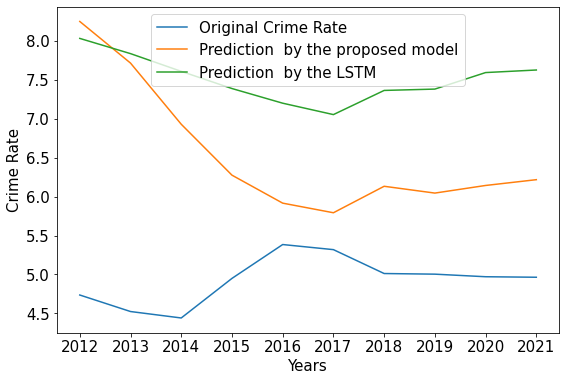

In [ ]:
y = [i for i in range(2012,2022)]
plt.figure(figsize=(9, 6))
plt.plot(y,y1, label = "Original Crime Rate")
plt.plot(y,y3, label = "Prediction  by the proposed model")
plt.plot(y,y2, label = "Prediction  by the LSTM")
plt.xlabel("Years")
plt.ylabel("Crime Rate")
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.legend()
plt.show()

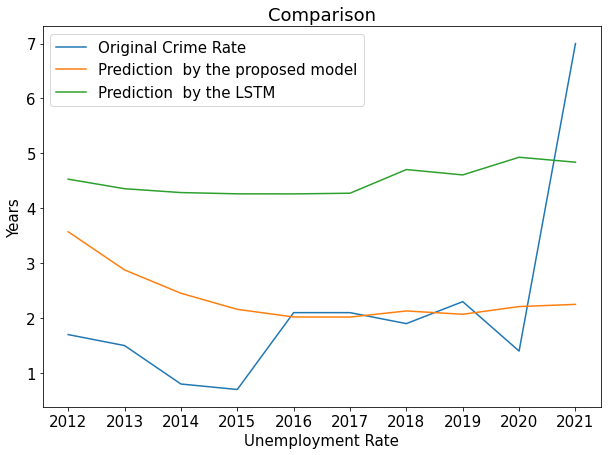

In [ ]:
y = [i for i in range(2012,2022)]
plt.figure(figsize=(10, 7))
plt.plot(y,unemploy1, label = "Original Crime Rate")
plt.plot(y,unemploy3, label = "Prediction  by the proposed model")
plt.plot(y,unemploy2, label = "Prediction  by the LSTM")
plt.xlabel("Unemployment Rate")
plt.ylabel("Years")
plt.title('Comparison')
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.legend()
plt.show()

In [ ]:
last_pred = y3[-1]
fut_pred = krs_ft.best_model.predict(X_fut_pred)
fut_prediction = []
for i,col in enumerate(df.columns):
  if col==column_matter:
    kr = True
    for a in fut_pred[...,i]:
      if kr:
        fut_prediction.extend(a)
        kr = False
      else:
        fut_prediction.append(a[-1])
print("Prediction for the years after 2022: ",[last_pred+a for a in fut_prediction])

Prediction for the years after 2022:  [6.5113397, 6.2192287, 5.7092457, 5.2986264, 5.0928035, 5.033726]


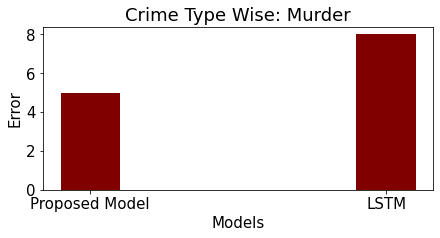

In [ ]:
victim_wise = [4.98, 7.98]
models = ['Proposed Model','LSTM']
fig = plt.figure(figsize = (7, 3))
plt.bar(models, victim_wise, color ='maroon', width = 0.2)
plt.xlabel("Models")
plt.ylabel("Error")
plt.title("Crime Type Wise: Murder")
plt.show()

In [ ]:
print(unemploy3)

[3.5728965, 2.877616, 2.4532108, 2.1598601, 2.0207663, 2.0194798, 2.130462, 2.0700557, 2.2104745, 2.2505796]
